# Dataset & Preprocessing

In [1]:
MAX_LENGTH = 500
PADDING_INDEX = 0
SOS_INDEX = 1
EOS_INDEX = 2
UNK_INDEX = 3

In [2]:
class Tokenizer():
    def __init__(self, vocab_from):
        vs, gi, gc = self._build_vocab(vocab_from)
        self.vocab_size, self.get_ind, self.get_chr = vs, gi, gc
        
    def _build_vocab(self, file_path):
        vocab_size = 4
        get_ind, get_chr = {'<p>': 0, '<s>': 1, '</s>': 2, '<u>': 3}, {0: '<p>', 1: '<s>', 2: '</s>', 3: '<u>'}

        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                for chr in line:
                    if chr == '\n' or chr in get_ind:
                        continue

                    get_ind[chr] = vocab_size
                    get_chr[vocab_size] = chr
                    vocab_size += 1

        return vocab_size, get_ind, get_chr

    def encode(self, text):
        return [self.get_ind['<s>']] + [self.get_ind[chr] if chr in self.get_ind else self.get_ind['<u>'] for chr in text] + [self.get_ind['</s>']]

    def decode(self, indices):
        return ''.join([self.get_chr[ind] for ind in indices if ind not in [self.get_ind['<p>'], self.get_ind['<s>'], self.get_ind['</s>'], self.get_ind['<u>']]])

In [5]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    sources, targets = zip(*data)
    sources = [torch.LongTensor(source)[:MAX_LENGTH] for source in sources]  # Cut off at MAX_LENGTH
    targets = [torch.LongTensor(target)[:MAX_LENGTH+1] for target in targets]  # Cut off at MAX_LENGTH + 1 to include EOS token

    # Pad sequences
    sources = pad_sequence(sources, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)

    return sources, targets

def get_data(split, src_tokenizer, tgt_tokenizer):
    src_file_path = f'/kaggle/input/dl-a3-data2vis/Q3/{split}.sources'
    tgt_file_path = f'/kaggle/input/dl-a3-data2vis/Q3/{split}.targets'

    sources = []
    with open(src_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            sources.append(src_tokenizer.encode(line))
    
    targets = []
    with open(tgt_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            targets.append(tgt_tokenizer.encode(line))
    
    data = [(sources[i], targets[i]) for i in range(len(sources))]
    return data

def get_dataloader(split, src_tokenizer, tgt_tokenizer, batch_size=32, shuffle=True):
    src_file_path = f'Data/Q3/{split}.sources'
    tgt_file_path = f'Data/Q3/{split}.targets'

    sources = []
    with open(src_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            sources.append(src_tokenizer.encode(line))
    
    targets = []
    with open(tgt_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            targets.append(tgt_tokenizer.encode(line))
    
    data = [(sources[i], targets[i]) for i in range(len(sources))]
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

def get_random_subset_dataloader(full_data, subset_ratio, batch_size):
    num_samples = int(len(full_data) * subset_ratio)
    subset_indices = random.sample(range(len(full_data)), num_samples)
    subset_data = [full_data[i] for i in subset_indices]
    
    subset_loader = DataLoader(subset_data, batch_size=batch_size, collate_fn=collate_fn)
    return subset_loader

In [6]:
src_tokenizer = Tokenizer('Data/Q3/train.sources')
tgt_tokenizer = Tokenizer('Data/Q3/train.targets')
train_loader = get_dataloader('dev', src_tokenizer, tgt_tokenizer, batch_size=5)

for src, tgt in train_loader:
    print(src.shape, tgt.shape, src.dtype, tgt.dtype)
    print(src)
    print(tgt)
    break

torch.Size([5, 351]) torch.Size([5, 257]) torch.int64 torch.int64
tensor([[ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  4,  5,  ...,  3,  2,  0],
        [ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  4,  5,  ..., 44,  3,  2],
        [ 1,  4,  5,  ...,  0,  0,  0]])
tensor([[ 1,  4,  5,  ...,  3,  2,  0],
        [ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  4,  5,  ..., 29,  3,  2]])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Model Architecture

In [8]:
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [9]:
from tqdm import tqdm

class Focused(nn.Module):
    def __init__(self, src_vs, tgt_vs, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.5):
        super(Focused, self).__init__()

        self.embedding_encoder = nn.Embedding(src_vs, embedding_dim)
        self.rnn_encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout, batch_first=True)
        
        self.embedding_decoder = nn.Embedding(tgt_vs, embedding_dim)
        self.rnn_decoder = nn.LSTM(embedding_dim, 2*hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, tgt_vs)

        self.reduce = nn.Linear(embedding_dim + 2*hidden_dim, embedding_dim)

    def encode(self, src):
        embedded = self.embedding_encoder(src)  # [batch_size, seq_len, embedding_dim]
        encoder_outputs, (hidden, _) = self.rnn_encoder(embedded)  # hidden: [num_layers*2, batch_size, hidden_dim]
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1).unsqueeze(0).expand(self.rnn_decoder.num_layers, -1, -1).contiguous()  # [num_layers, batch_size, 2*hidden_dim]
        return encoder_outputs, hidden
    
    def attention_layer(self, encoder_outputs, hidden):
        batch_size, seq_len, _ = encoder_outputs.size()
        
        hidden_last = hidden[-1].unsqueeze(1)  # [batch_size, 1, 2*hidden_dim]
        attention_weights = torch.bmm(hidden_last, encoder_outputs.permute(0, 2, 1))  # [batch_size, 1, seq_len]

        mask = (encoder_outputs.sum(dim=2) == PADDING_INDEX).unsqueeze(1)  # [batch_size, 1, seq_len]
        attention_weights = attention_weights.masked_fill(mask, -float('inf'))
        attention_weights = F.softmax(attention_weights, dim=2)

        context_vector = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, 2*hidden_dim]
        return context_vector

    def decode(self, tgt, encoder_outputs, hidden):
        embedded = self.embedding_decoder(tgt)  # [batch_size, seq_len, embedding_dim]
        context_vector = self.attention_layer(encoder_outputs, hidden)  # [batch_size, 1, 2*hidden_dim]
        context_vector = context_vector.expand(-1, embedded.size(1), -1)  # [batch_size, seq_len, 2*hidden_dim]
        embedded = torch.cat((embedded, context_vector), dim=2)  # [batch_size, seq_len, embedding_dim + 2*hidden_dim]
        embedded = self.reduce(embedded)  # [batch_size, seq_len, embedding_dim]
        output, hidden = self.rnn_decoder(embedded, (hidden, torch.zeros_like(hidden)))  # output: [batch_size, seq_len, 2*hidden_dim]
        output = self.linear(output)  # [batch_size, seq_len, tgt_vs]
        return output, hidden

    def forward(self, src, tgt):
        encoder_outputs, encoder_hidden = self.encode(src)
        decoder_output, _ = self.decode(tgt, encoder_outputs, encoder_hidden)
        return decoder_output

In [10]:
embedding_dim = 512
hidden_dim = 512
num_layers = 2

foc = Focused(src_tokenizer.vocab_size, tgt_tokenizer.vocab_size, embedding_dim, hidden_dim, num_layers)

for src, tgt in train_loader:
    # src, tgt = src.to(device), tgt.to(device)
    print(src.shape, tgt.shape)

    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]

    encoder_output, hidden = foc.encode(src)
    print(encoder_output.shape, hidden.shape)

    output = foc(src, tgt_input)
    print(output.shape)
    break

torch.Size([5, 292]) torch.Size([5, 236])
torch.Size([5, 292, 1024]) torch.Size([2, 5, 1024])
torch.Size([5, 235, 47])


# Training

In [11]:
from tqdm import tqdm

def train_step(model, src, tgt, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]

    output = model(src, tgt_input)
    loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
    loss.backward()
    optimizer.step()

    return loss.item()

def eval_step(model, eval_loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(eval_loader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(eval_loader)

In [25]:
# set seed
torch.random.manual_seed(1)

# setup model
embedding_dim = 512
hidden_dim = 512
num_layers = 2

src_tokenizer = Tokenizer('Data/Q3/train.sources')
tgt_tokenizer = Tokenizer('Data/Q3/train.targets')
model = Focused(src_tokenizer.vocab_size, tgt_tokenizer.vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(ignore_index=PADDING_INDEX)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

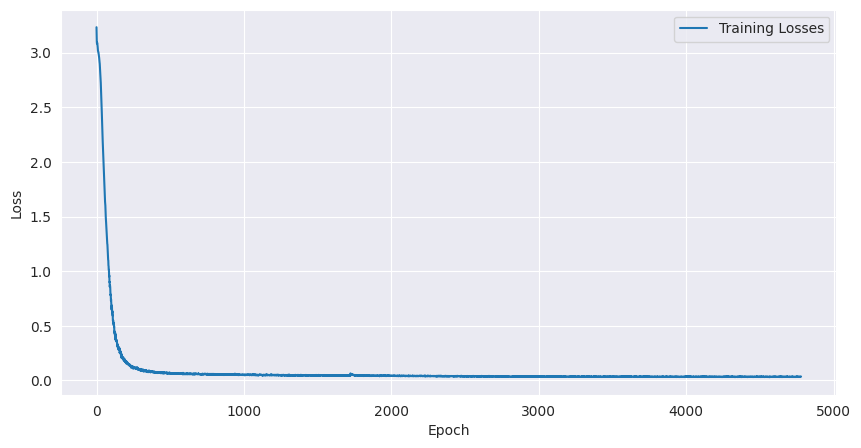

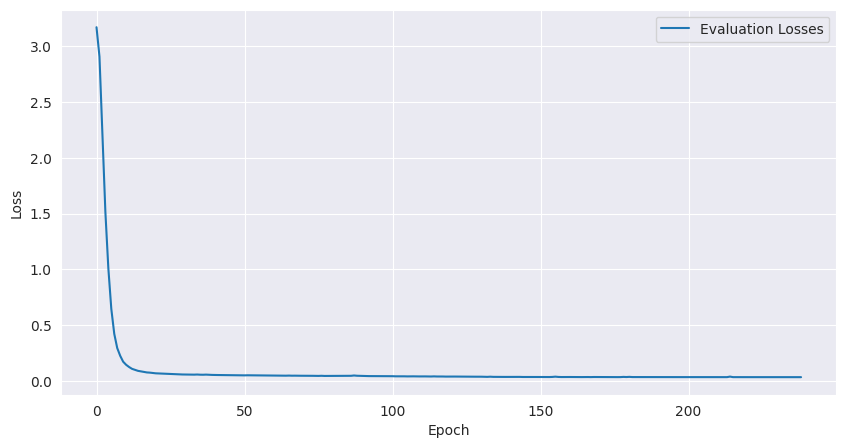

- step 4780 - loss 0.032325343995848126 - perp 1.0328534833273302


 76%|███████▋  | 52/68 [00:09<00:03,  5.24it/s]


KeyboardInterrupt: 

In [41]:
import seaborn as sns
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch.utils.data import DataLoader, SubsetRandomSampler

sns.set_style('darkgrid')

def plot_losses(train_losses, label):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# train loop
train_losses = []
eval_losses = []

best_eval_loss = float('inf')
best_perp = float('inf')

train_loader = get_dataloader('train', src_tokenizer, tgt_tokenizer, batch_size=32)
eval_loader = get_dataloader('dev', src_tokenizer, tgt_tokenizer, batch_size=32)
eval_data = get_data('dev', src_tokenizer, tgt_tokenizer)

max_steps = 20000
step = 0

while True:
    for src, tgt in train_loader:
        clear_output(wait=True)

        plot_losses(train_losses, "Training Losses")
        plot_losses(eval_losses, "Evaluation Losses")
        print(f'- step {step} - loss {best_eval_loss} - perp {best_perp}')

        src, tgt = src.to(device), tgt.to(device)
        train_loss = train_step(model, src, tgt, criterion, optimizer)
        train_losses.append(train_loss)

        if step % 20 == 0:
            subset_eval_loader = get_random_subset_dataloader(eval_data, 0.1, batch_size=32)
            eval_loss = eval_step(model, subset_eval_loader, criterion)
            eval_losses.append(eval_loss)

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                best_perp = math.exp(eval_loss)
                torch.save(model.state_dict(), 'Models/Q3/model.bin')

        step += 1
        if step > max_steps:
            break

# Load Models

In [12]:
embedding_dim = 512
hidden_dim = 512
num_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

src_tokenizer = Tokenizer('Data/Q3/train.sources')
tgt_tokenizer = Tokenizer('Data/Q3/train.targets')
model = Focused(src_tokenizer.vocab_size, tgt_tokenizer.vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

model.load_state_dict(torch.load('Models/Q3/model.bin', map_location=device))
model.eval()

Focused(
  (embedding_encoder): Embedding(89, 512)
  (rnn_encoder): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (embedding_decoder): Embedding(47, 512)
  (rnn_decoder): LSTM(512, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=1024, out_features=47, bias=True)
  (reduce): Linear(in_features=1536, out_features=512, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_INDEX)
eval_loader = get_dataloader('test', src_tokenizer, tgt_tokenizer, batch_size=32)
eval_step(model, eval_loader, criterion)

100%|██████████| 675/675 [02:36<00:00,  4.31it/s]


0.032568769717106115

In [13]:
# {"year": "1956", "race": "3000m", "Time": "7.925", "Distance": "3"}
# i rename columns and remove the unit
indices = src_tokenizer.encode('[{"num0": "2003", "num0": "500", "num1": "0.238", "num2": "9.23"}]')
src = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from IPython.display import clear_output
import time

def beam_search_decode(model, src, beam_width, max_length, temperature, alpha):
    model.eval()
    
    tgt = torch.tensor([SOS_INDEX]).unsqueeze(0).to(device)
    src_len, _ = src.size()
    
    current_beams = [(0, tgt)]  # (cumulative_log_prob, sequence)
    
    for _ in range(max_length):
        new_beams = []
        all_sequences_end = True
        
        for cumulative_log_prob, seq in current_beams:
            if seq[0, -1].item() == EOS_INDEX:
                new_beams.append((cumulative_log_prob, seq))
                continue
            
            all_sequences_end = False

            with torch.no_grad():
                logits = model(src.expand(seq.size(0), -1), seq)
            logits = logits[:, -1, :] / temperature
            log_probs = F.log_softmax(logits, dim=-1)
            
            diversity_penalty = torch.pow(log_probs.exp(), alpha) * log_probs
            adjusted_log_probs = log_probs - diversity_penalty
            
            topk_log_probs, topk_indices = adjusted_log_probs.topk(beam_width)
            
            for log_prob, index in zip(topk_log_probs[0], topk_indices[0]):
                new_seq = torch.cat([seq, index.view(1, 1)], dim=1)
                new_cumulative_log_prob = cumulative_log_prob + log_prob.item()
                new_beams.append((new_cumulative_log_prob, new_seq))
        
        current_beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
        
        clear_output(wait=True)
        for score, seq in current_beams:
            decoded_seq = tgt_tokenizer.decode(seq[0].tolist())
            print(f"{decoded_seq}")
        
        # with open("sequences.txt", "w") as file:
        #     for score, seq in current_beams:
        #         decoded_seq = tgt_tokenizer.decode(seq[0].tolist())
        #         file.write(f"{decoded_seq}\n")
        
        if all_sequences_end:
            break
    
    # Extract and return sequences from beams
    sequences = [seq[0].tolist() for _, seq in current_beams]
    return sequences

In [17]:
all_text = beam_search_decode(model, src, beam_width=20, max_length=2000, temperature=4, alpha=1.5)


{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}},
{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, 
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}},
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, 
{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "bar"}
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate

In [18]:
for text in all_text:
    print(tgt_tokenizer.decode(text))


{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}},
{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, 
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}},
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, 
{"encoding": {"y": {"field": "str3", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate": "count", "type": "quantitative"}}, "mark": "bar"}
{"encoding": {"y": {"field": "str4", "type": "nominal", "primitiveType": "string", "selected": true}, "x": {"field": "*", "aggregate